## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 1 - Basic ML Classifiers

In this task, you are going to implement two classifers and apply them to the Fashion-MNIST dataset: 

(1) Logistic regression classifier

(2) Softmax classifier.

In [116]:
# Import modules, make sure you have installed all required packages before you start.
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Fashion-MNIST data

Fashion-MNIST is a widely used dataset mainly used for benchmarking machine learning models. Images are drawn from Zalando's clothing articles and the dataset consists of a training set with 60,000 examples and a test set with 10,000 examples. Each example is a 28x28 pixel grayscale image with an associated label from 10 classes. We will use this to create our training set, validation set, and test set.

See https://github.com/zalandoresearch/fashion-mnist for more details on Fashion-MNIST. 

### 10-class dataset Fashion-MNIST
First, we load the raw Fashion-MNIST data to create a 10-class dataset and manually define a label map.

In [117]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

# the integer labels in y_train and y_test correspond to the index of this label map
label_map = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Here we vectorize the data (rearranged the storage of images) for you. 
# That is, we flatten 1×28×28 images into 1×784 Numpy arrays.
# The reason we do this is because we can not put 2-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML model). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs in later assignments.

# Check the results
print('Raw training data shape: ', X_train_raw.shape)
print('Raw test data shape: ', X_test_raw.shape)

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

print('Vectorized training data shape: ', X_train.shape)
print('Vectorized test data shape: ', X_test.shape)

print('Training labels shape: ', y_train.shape)
print('Test labels shape: ', y_test.shape)

Raw training data shape:  (60000, 28, 28)
Raw test data shape:  (10000, 28, 28)
Vectorized training data shape:  (60000, 784)
Vectorized test data shape:  (10000, 784)
Training labels shape:  (60000,)
Test labels shape:  (10000,)


['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
(60000, 28, 28)


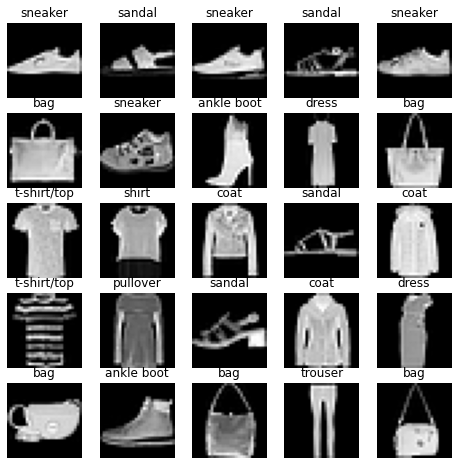

In [118]:
# Visualization Step

# We need to reshape vectorized data into the image format for visualization
X = X_train.reshape(X_train.shape[0], X_train_raw.shape[1], X_train_raw.shape[2])

print(label_map)
print(X.shape)

#Visualizing Fashion-MNIST data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0], cmap='gray')
        axes1[j][k].set_title(label_map[y_train[i]])

In [119]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
#    Development data (binary) (only for gradient check in Part 1): 100 random samples from the subsampled binary train set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100
num_dev_binary = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (1000, 784)
Test labels shape:  (1000,)
Development data shape: (100, 784)
Development data shape (100,)


### 2-class dataset
Next, in order to implement the experiment with the logistic regression classifier, we subsample the 10-class dataset to the 2-class dataset. 

In [120]:
# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
num_training_binary = X_train_binary.shape[0]
y_train_binary = y_train[y_train<2]
mask_binary = np.random.choice(num_training_binary, num_dev_binary, replace=False)

# Only 0 and 1 class
X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]

X_dev_binary = X_train_binary[mask_binary]
y_dev_binary = y_train_binary[mask_binary]


print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)
print('Development data (binary) shape:', X_dev_binary.shape)
print('Development data (binary) shape', y_dev_binary.shape)

Train data (binary) shape:  (9775, 784)
Train labels (binary) shape:  (9775,)
Validation data (binary) shape:  (207, 784)
Validation labels (binary) shape:  (207,)
Development data (binary) shape: (100, 784)
Development data (binary) shape (100,)


In [121]:
# Preprocessing: subtract the mean value across every dimension, for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

# Preprocessing: subtract the mean value across every dimension, for binary training data
mean_image = np.mean(X_train_binary, axis=0)

X_train_binary = X_train_binary.astype(np.float32) - mean_image.astype(np.float32)
X_val_binary = X_val_binary.astype(np.float32) - mean_image
X_dev_binary = X_dev_binary.astype(np.float32) - mean_image

## Part 1: Logistic Regression Classifier

In this part, you are going to implement a logistic regression classifier. 

Let’s assume a training dataset of images $x_i \in R^D$, each with an associated label $y_i$. We have that $i=1 \dots N$ and $y_i \in 1 \dots K$, where **N** represents the number of examples (each with a dimensionality **D**) and **K** represents the number of distinct classes.

#### **Start detailed data description** (feel free to skip if you feel you understand)

    N: number of input images (examples)
    D: dimension of one input image
    K: number of classes

For the Fashion-MNIST dataset we have training examples `X_train` with shape $(49,000, 784)$ and the corresponding labels `y_train` with shape $(4910,)$.

Here number of input data (images) is: $N=49,000$, and each image has a flattened dimension: $D=784$ ($28\times28$).

So we have: $$X: N \times D$$  $$y: N \times 1$$

Think about one single image in $X$, represented as: $x_i \in R^D$ ($x_i: 1\times D$)

it is associated with a label $y_i$. Here $i=1 \dots N$ and $y_i \in 1 \dots K$.

#### **End detailed data description**

We will now define the score function $f: R^D \to R^K$ that maps the raw image pixels to class scores: $$f(x_i; W, b)=W x_i + b$$
where $W$ is of size $D \times K$ and $b$ is of size $1 \times K$. 

Here we will use **bias trick** to represent the two parameters $W,b$ as one by extending the vector $x_i$ with one additional dimension that always holds the constant **1** - a default bias dimension. With the extra dimension, the new score function will simplify to a single matrix multiply: $$f = f(x_i;W)=W x_i$$

For our data:

$$D=784+1=785$$


<span style="color:red"><strong>TODO</strong></span>:  Implement the bias trick by extending the feature vectors. In our case this involves adding a bias dimension of ones to each of `X_train`, `X_val`, `X_test`, `X_dev`, `X_train_binary`, `X_val_binary`, and `X_dev_binary`.

<span style="color:red"><strong>HINT</strong></span>: Make your life easier with `np.hstack`. https://numpy.org/doc/stable/reference/generated/numpy.hstack.html

<span style="color:red"><strong>SOLUTION</strong></span>:

In [122]:
#############################################################
# TODO: Append the bias dimension of ones (i.e. bias trick) so that our models
# only have to worry about optimizing a single weight matrix W.
# START of your code
#############################################################

# Define bias trick
def bias_trick(array : np.array):
    bias = np.ones((array.shape[0],1))
    return np.hstack((array,bias))

# Assignment
X_train = bias_trick(X_train)
X_val = bias_trick(X_val)
X_test = bias_trick(X_test)
X_dev = bias_trick(X_dev)
X_train_binary = bias_trick(X_train_binary)
X_val_binary = bias_trick(X_val_binary)
X_dev_binary = bias_trick(X_dev_binary)


#############################################################
# END of your code
#############################################################

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("X_dev shape: {}".format(X_dev.shape))
print("X_train_binary shape: {}".format(X_train_binary.shape))
print("X_val_binary shape: {}".format(X_val_binary.shape))
print("X_dev_binary shape: {}".format(X_dev_binary.shape))

X_train shape: (49000, 785)
X_val shape: (1000, 785)
X_test shape: (1000, 785)
X_dev shape: (100, 785)
X_train_binary shape: (9775, 785)
X_val_binary shape: (207, 785)
X_dev_binary shape: (100, 785)


**Brief introduction to logistic regression classifier**

Logistic regression classifier can solve a binary classification problem ($K=2$). A binary logistic regression classifier has only two classes (0,1), and calculates the probability of class 1 as:

$$
P(y=1 | x ; w)=\frac{1}{1+e^{-f}}=\sigma\left(f\right)
$$

Since the probabilities of class 1 and 0 sum to one, the probability for class 0 is:

$$
P(y=0 | x ; w)=1-P(y=1 | x ; w)
$$

Hence, an example is classified as a positive example ($y = 1$) if $\sigma\left(f\right)>0.5$, or equivalently if the score $f>0$. The loss function then maximizes the log likelihood of this probability over all examples. You can convince yourself that this simplifies to:

$$
L_{i}=- (y_{i} \log \left(\sigma\left(f_{i}\right)\right)+\left(1-y_{i}\right) \log \left(1-\sigma\left(f_{i}\right)\right))
$$

and ultimately:

$$ L = \frac{1}{N}\sum_i L_i + reg\times\|W\|_2$$

where the labels $y_{i}$ are assumed to be either 1 (positive) or 0 (negative), and $\sigma(\cdot)$ is the sigmoid function. The expression above can look scary, but its gradients with respect to $f$ and $W$ are simple and intuitive: 

$$
\frac{\partial L_{i}}{\partial f}=-(y_{i}-\sigma\left(f_{j}\right))
$$

$$
\frac{\partial L_{i}}{\partial W}= - (y_{i}-\sigma\left(f_{j}\right)) * x_{i}
$$

[1] http://cs231n.github.io/neural-networks-2/

[2] https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
    

<span style="color:red"><strong>TODO</strong></span>: Complete the code in **./utils/classifiers/logistic_regression.py**. You have to implement logistic regression in two ways: 
naive and vectorized.
We provide the verification code for you to check if your code works properly.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below.

In [123]:
# Verification code for checking the correctness of the implementation of logistic_regression
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #
from utils.classifiers.logistic_regression import logistic_regression_loss_naive
from utils.classifiers.logistic_regression import logistic_regression_loss_vectorized

# generate a random weight matrix seeded with small numbers
np.random.seed(3456)
W = np.random.randn(X_train.shape[1], 1) * 0.0001  # generate initial weight vector with shape of feature vector transposed

## naive numpy implementation of Logistic Regression
loss_naive, grad_naive = logistic_regression_loss_naive(W, X_dev_binary, y_dev_binary, 0.000005)
print('naive numpy loss: {}.'.format(loss_naive))

## vectorized numpy implementation of Logistic Regression
loss_vec, grad_vec = logistic_regression_loss_vectorized(W, X_dev_binary, y_dev_binary, 0.000005)
print('vectorized numpy loss: {}.'.format(loss_vec))

## check the correctness
print('*'*100)
print('Relative loss error is {}'.format(abs(loss_vec-loss_naive)))
grad_err = np.linalg.norm(grad_naive - grad_vec)#, ord='fro')
print('Relative gradient error is {}'.format(grad_err))
print('*'*100)
print('Is vectorized loss correct? {}'.format(np.allclose(loss_naive, loss_vec)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_naive, grad_vec)))

naive numpy loss: -81.44177829773918.
vectorized numpy loss: -81.44177829773918.
****************************************************************************************************
Relative loss error is 0.0
Relative gradient error is 7.81591477880227e-12
****************************************************************************************************
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax Classifier

The softmax classifier generalizes the logistic regression classifier to multiple classes.

In the softmax classifier, the function mapping $f(x_i;W)=W x_i$ stays unchanged, but we now interpret the obtained scores as the unnormalized log probabilities for each class (instead of using the sigmoid function to yeild probabilities), and replace the logistic regression loss with a cross-entropy loss that has the form: $$L_i= - \log (\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}).$$

The cross-entropy between a “true” distribution $p$ and an estimated distribution $q$ is defined as: $$H(p, q)=- \sum_x p(x) \log q(x).$$

Now, let's rewrite the expression of $L_i$: $$L_i= - \sum_k p_{i,k} \log (\frac{e^{f_k}}{\sum_j e^{f_j}})$$
where $p_i=[0, \dots,1, \dots, 0]$ contains a single 1 at the $y_i$-th position, $p_{i,k}=p_i[k]$, $p_i \in [1 \times K]$.

**Note:** Numerical stability. When you are writing code for computing the Softmax function in practice, the intermediate terms $e^{f_{y_i}}$ and $\sum_j e^{f_j}$ may be very large due to the exponentials. Dividing with large numbers can be numerically unstable, so it is important to use the normalization trick. Notice that if we multiply both the top and the bottom of the fraction by constant $C$ and push $C$ inside the exponent, we get the following (mathematically equivalent) expression: $$\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}=\frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}=\frac{e^{f_{y_i}+\log C}}{\sum_j e^{f_j+\log C}}.$$

A common choice for $C$ is to set it to $\log C= -\max_j f_j$.

In most cases, you also need to consider a bias term $b$ with length D. However, in this experiment, since a bias dimension has been added into the $X$, you can ignore it. 

**Softmax derivations (in matrix representation)**

$$\nabla_{W_k} L= - \frac{1}{N} \sum_i x_i^T(p_{i,m} - P_m) + 2 \lambda W_k,$$
where $P_k= \frac{e^{f_k}}{\sum_j e^{f_j}}$.

<span style="color:red"><strong>TODO</strong></span>: Complete the code in **./utils/classifiers/softmax.py**.You have to implement the softmax layer in three ways. For the first two implementations, we provide the verification code for you to check if your implementation is correct. 

* Naive method using for-loop
* Vectorized method

Do not forget the $L_2$ regularization term in the loss.

Softmax in Tensorflow is demonstrated in the verification code below. This step will familiarize you with TensorFlow functions.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below.

In [124]:
# Verification code for checking the correctness of the implementation of softmax implementations
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.softmax import softmax_loss_naive
from utils.classifiers.softmax import softmax_loss_vectorized

## generate a random weight matrix of small numbers
np.random.seed(3456)
W = np.random.randn(X_train.shape[1], 20) * 0.0001
W_tf = tf.Variable(W, dtype = tf.float32)
X = tf.Variable(X_dev, dtype = tf.float32)
y = tf.Variable(y_dev, dtype = tf.int32)
reg = tf.constant(0.000005)


with tf.GradientTape() as tape:
    tape.watch(W_tf)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,20))
    loss_gt = tf.reduce_mean(cross_entropy) + reg * tf.reduce_sum(W_tf * W_tf)   
    grad_gt = tape.gradient(loss_gt, W_tf)

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## Verify your result here - use 'rel_err' for error evaluation.
def rel_err(a,b):
    return np.mean(abs(a-b))

print('*'*100)
print('Relative loss error of naive softmax is {}'.format(rel_err(loss_gt,loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(rel_err(loss_gt,loss_vec)))
print('Gradient error of naive softmax is {}'.format(rel_err(grad_gt,grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(rel_err(grad_gt,grad_vec)))
print('*'*100)
print('Is naive softmax loss correct? {}'.format(np.allclose(loss_gt, loss_naive)))
print('Is vectorized softmax loss correct? {}'.format(np.allclose(loss_gt, loss_vec)))
print('Is naive softmax grad correct? {}'.format(np.allclose(grad_gt, grad_naive,1e-02)))
print('Is vectorized softmax grad correct? {}'.format(np.allclose(grad_gt, grad_vec,1e-02)))

naive numpy loss: 3.0228233266060123, takes 0.0020766258239746094 seconds.
vectorized numpy loss: 3.0228233266060136, takes 0.013576269149780273 seconds.
****************************************************************************************************
Relative loss error of naive softmax is 2.384185791015625e-07
Relative loss error of vectorized softmax is 2.384185791015625e-07
Gradient error of naive softmax is 2.640421428168338e-07
Gradient error of vectorized softmax is 2.640421428168338e-07
****************************************************************************************************
Is naive softmax loss correct? True
Is vectorized softmax loss correct? True
Is naive softmax grad correct? True
Is vectorized softmax grad correct? True


## Part 3: Train your classifiers

Now you can start to train your classifiers. We are going to use gradient descent algorithm for training, which differs from the usual logistic regression training process. 

<span style="color:red"><strong>TODO</strong></span>: The original code is given in **./utils/classifiers/basic_classifier.py**. You need to complete functions **train** and **predict**, in the class **BasicClassifier**. Later, you use its subclasses **Logistic Regression** and **Softmax** to train the model seperately and verify your result.


In the training section, you are asked to implement Stochastic gradient descent (SGD) optimization method. Pseudo code for SGD is shown below.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```

### Train Logistic Regression + Stochastic Gradient Descent (SGD)

<span style="color:red"><strong>TODO</strong></span>: Complete the code of subclasses **Logistic_Regression** in **./utils/classifiers/basic_classifiers.py**. 

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [125]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.basic_classifiers import Logistic_Regression

## Logistic Regression + SGD
classifier = Logistic_Regression()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both 
# training set and validation set
y_train_pred = classifier.predict(X_train_binary)
print('training accuracy: %f' % (np.mean(y_train_binary == y_train_pred), ))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy: %f' % (np.mean(y_val_binary == y_val_pred), ))

iteration 0 / 1500: loss -100.235464
iteration 100 / 1500: loss -6.711724
iteration 200 / 1500: loss -2.795070
iteration 300 / 1500: loss -3.980957
iteration 400 / 1500: loss -3.820627
iteration 500 / 1500: loss -1.016760
iteration 600 / 1500: loss -2.051181
iteration 700 / 1500: loss -2.671158
iteration 800 / 1500: loss -0.307511
iteration 900 / 1500: loss -4.056164
iteration 1000 / 1500: loss -2.178934
iteration 1100 / 1500: loss -1.066129
iteration 1200 / 1500: loss -0.333247
iteration 1300 / 1500: loss -9.288441
iteration 1400 / 1500: loss -2.501393
training accuracy: 0.993146
validation accuracy: 0.995169


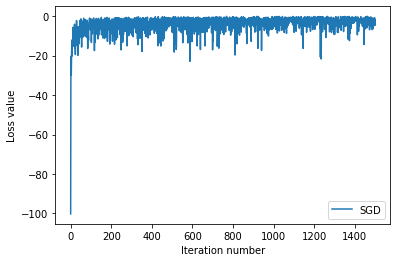

In [126]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

<span style="color:red"><strong>TODO</strong></span>: Complete the code of subclasses **Softmax** in **./utils/classifiers/basic_classifier.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [127]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.basic_classifiers import Softmax

## Softmax + SGD
classifier = Softmax()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 4.060507
iteration 100 / 1500: loss 2.337843
iteration 200 / 1500: loss 1.876826
iteration 300 / 1500: loss 1.536152
iteration 400 / 1500: loss 1.305638
iteration 500 / 1500: loss 1.223978
iteration 600 / 1500: loss 1.064535
iteration 700 / 1500: loss 0.868583
iteration 800 / 1500: loss 1.042411
iteration 900 / 1500: loss 1.012153
iteration 1000 / 1500: loss 0.910858
iteration 1100 / 1500: loss 0.933643
iteration 1200 / 1500: loss 0.993881
iteration 1300 / 1500: loss 1.078052
iteration 1400 / 1500: loss 0.929142
training accuracy: 0.692776
validation accuracy: 0.697000


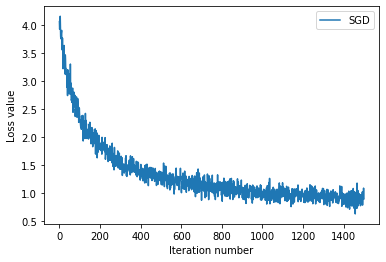

In [128]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()